In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup

Import the data. In several lines there are too many commas and read_csv is confused with the delimiter. If we choose to omit these lines, we see from the response below that only a negligible amount of lines is omitted, so it is ok. 

In [2]:
data=pd.read_csv('Sentiment Analysis Dataset.csv',error_bad_lines=False)
data.drop(['ItemID','SentimentSource'],axis=1,inplace=True)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [3]:
print(data.shape)

(1578612, 2)


For the training let's use the random sample of 200 000 tweets:

In [4]:
data=data.sample(200000)

For now let's remove all the non-Latin letters and other characters. It might be a good idea to analyse emoji as well, however, twitter is full of sarcasm so this part might remain for future research. 

In [5]:
nltk.download('wordnet')
tokenizer=nltk.tokenize.TreebankWordTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/anna_s/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def text_prepare(df, text_field):
    df[text_field]=df.apply(lambda row: BeautifulSoup(row[text_field]).get_text(), axis=1) #convert html encoding to text
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"http\S+", "") #remove links
    df[text_field] = df[text_field].str.replace(r"www.\S+", "") #remove links
    df[text_field] = df[text_field].str.replace(r"@\S+", "") #remove mentions
    df[text_field] = df[text_field].str.replace(r"[^a-z\']", " ") #remove non-Latin symbols
    df[text_field] = df[text_field].str.replace(r" +", " ") #remove additional white spaces
    df[text_field] = df[text_field].str.replace(r"(.)\1+", r"\1\1") #remove repeating characters
    df.dropna(subset=[text_field],inplace=True)
    #lemmatize all words in text to analyze only the stem of the words in use
    df[text_field]=df.apply(lambda row: ' '.join([lemmatizer.lemmatize(t) for t in tokenizer.tokenize(row[text_field])]), axis=1)
    #replace some most popular non-words 
    df[text_field] = df[text_field].str.replace("n't", "not")
    df[text_field] = df[text_field].str.replace("'m", "am")
    df[text_field] = df[text_field].str.replace("im", "i am")
    df[text_field] = df[text_field].str.replace("mi", "my")
    return df

In [7]:
cleaned_data=text_prepare(data, 'SentimentText')
print(cleaned_data.head())

         Sentiment                                      SentimentText
164622           0  he 's managing a pizza shop but it mean that i...
269915           1  there ha been a problem with twitteriffic sinc...
28592            0                                    i am sorry babe
999643           1                                    jack in a crack
1311993          0                                                hug


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(cleaned_data['SentimentText'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

The code below shows the top-10 most positive words and top-10 most negative words (words more frequent with positive and negative labels respectively) using the sparse matrix. 
Idea taken from: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913


In [9]:
pos_matrix = cvec.transform(cleaned_data[cleaned_data['Sentiment'] == 1]['SentimentText'])
neg_matrix = cvec.transform(cleaned_data[cleaned_data['Sentiment'] == 0]['SentimentText'])
pos_tf = np.sum(pos_matrix,axis=0)
neg_tf = np.sum(neg_matrix,axis=0)
pos = np.squeeze(np.asarray(pos_tf))
neg = np.squeeze(np.asarray(neg_tf))
term_freq_df = pd.DataFrame([pos,neg],columns=cvec.get_feature_names()).transpose()
term_freq_df.columns = ['positive','negative']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

In [10]:
print(term_freq_df.sort_values(by='positive', ascending=False)['positive'].iloc[:10])
print(term_freq_df.sort_values(by='negative', ascending=False)['negative'].iloc[:10])

the    33473
to     31499
you    24657
it     21093
and    18884
my     15892
for    14858
is     13975
am     13903
in     12675
Name: positive, dtype: int64
to     39540
the    32568
not    24874
my     23695
it     23296
am     19259
and    19194
is     16840
in     14594
you    13001
Name: negative, dtype: int64


From the results above we see that the most frequent positive and negative words are the same (actually, these are the words that would not help classify tweets - stopwords).

In [11]:
term_freq_df=term_freq_df.sort_values(by='total', ascending=False)

The plot below shows the frequency of 500 most popular words. 

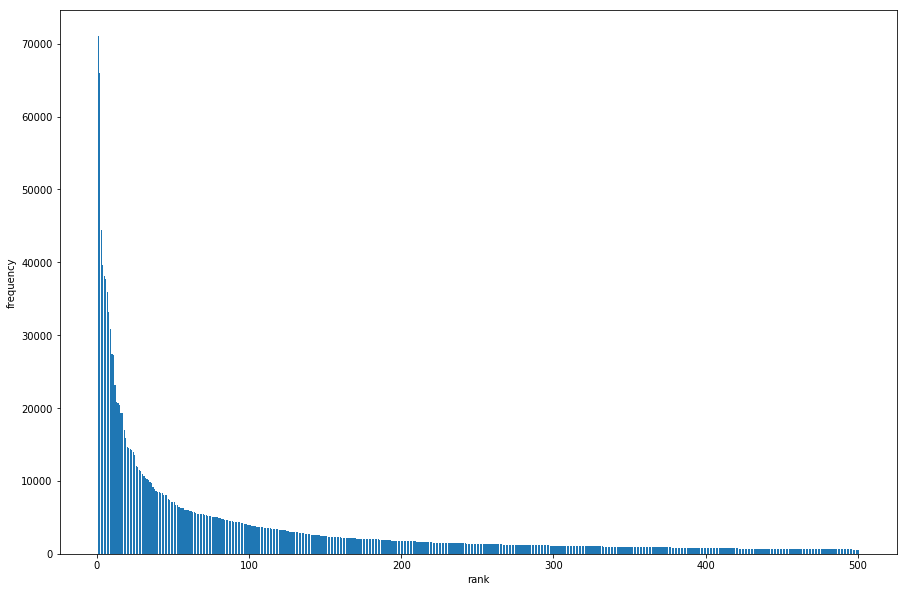

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
x=np.arange(1,term_freq_df.shape[0]+1)
plt.bar(x[:500],term_freq_df['total'][:500])
plt.xlabel('rank')
plt.ylabel('frequency')
plt.show()

If we want to check the Zipf's law for all the words in the dataset, we need to assign the ranking properly so that the words with the same frequency have the same rank. 

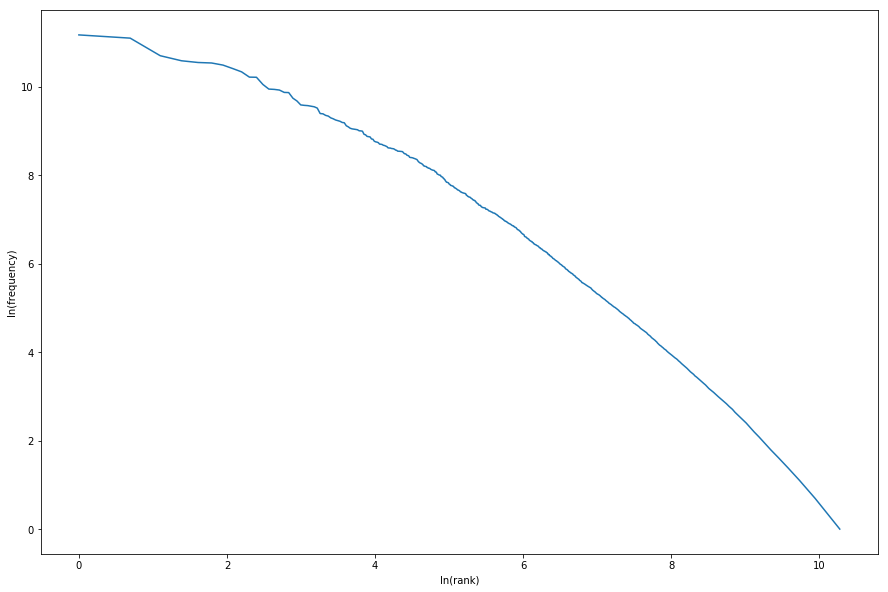

In [13]:
rank=term_freq_df['total'].rank(ascending=False,method='min')
plt.figure(figsize=(15,10))
plt.plot(np.log(rank),np.log(term_freq_df['total']))
plt.xlabel('ln(rank)')
plt.ylabel('ln(frequency)')
plt.show()

The plot above proves that Zipf's law holds for this dataset. 

Now that the data is cleaned we can apply the model to predict sentiment. Taking into account the size of the dataset, I will use logistic model for this classification. 
To analyze tweets and convert them into numerical data I will apply tf-idf vectorizer with various n-grams to account for phrases. 

Firstly, check that positive and negative tweets are evenly distributed:

In [14]:
print(cleaned_data[cleaned_data['Sentiment']==1].shape)
print(cleaned_data[cleaned_data['Sentiment']==0].shape)

(100096, 2)
(99904, 2)


Secondly, split the data into train and test sets. 

In [15]:
from sklearn.model_selection import train_test_split
x=cleaned_data['SentimentText']
y=cleaned_data['Sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.1, random_state=19)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
pipeline=Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),  # use unigrams, bigrams or trigrams
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  # use unigrams, bigrams or trigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': np.logspace(-4, 4, 5), #try different regularization 
    #'clf__penalty': ('l1', 'l2'),
}

In [17]:
estimator = GridSearchCV(pipeline,parameters,cv=5) #apply GridSearch to find best parameters
estimator.fit(x_train, y_train)
print(estimator.best_estimator_)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [18]:
from sklearn.metrics import accuracy_score
print('Accuracy on train set =',' ', accuracy_score(y_train, estimator.predict(x_train)))
print('Accuracy on test set =',' ', accuracy_score(y_test, estimator.predict(x_test)))

Accuracy on train set =   0.8763833333333333
Accuracy on test set =   0.8034


Now let's try to remove the words from the dataset that are the same in positive and negative sets as they might impede classification. Taking the default stopwords for English language might not be a good idea. For example, the default stopwords contain 'not' and we should not remove it, because when using n-grams, 'like' and 'not like' can make a huge contribution for classification. Therefore, I create my own set of stopwords out of the most frequent words. 

In [19]:
sw=['you','the', 'to','it','and','for','am','that','is','in','they','other','my','but', 'i', "'re", "'s", "'cause",
   'because','are', 'a', "'d"]

In [20]:
pipeline=Pipeline([
    ('vect', CountVectorizer(stop_words=sw)),
    ('tfidf', TfidfVectorizer(stop_words=sw)),
    ('clf', LogisticRegression())
])
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),  # use unigrams, bigrams or trigrams
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  # use unigrams, bigrams or trigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': np.logspace(-4, 4, 5), #try different regularization
    #'clf__penalty': ('l1', 'l2'),
}

In [21]:
estimator = GridSearchCV(pipeline,parameters,cv=5) #apply GridSearch to find best parameters
estimator.fit(x_train, y_train)
print(estimator.best_estimator_)
print('Accuracy on train set =',' ', accuracy_score(y_train, estimator.predict(x_train)))
print('Accuracy on test set =',' ', accuracy_score(y_test, estimator.predict(x_test)))

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Accuracy on train set =   0.8780888888888889
Accuracy on test set =   0.7991


Actually, we see that accuracy on test set has fallen after removing stop words. So a further analysis to improve the results can include:
    - playing around more with the lexical part, for example including more or better stopwords
    - comparing different models, for example SVC, naive bayes classifier or CNN (actually, CNN should achieve high results on this task)
    - trying different methods of text analysis, for example word2vec algorithm, or extending the model to incude emoji